In [1]:
dataset = "fmnist"
noise_type = "symmetric"
noise_rate = "5"
batch_size = 50
VIS_METHOD = "TimeVis"

In [2]:
import os, sys
import numpy as np
import torch
import json
import time

sys.path.append("..")
from singleVis.SingleVisualizationModel import VisModel
from singleVis.data import NormalDataProvider
from singleVis.eval.evaluator import Evaluator
from singleVis.projector import Projector, tfDVIProjector, TimeVisProjector

In [3]:
inject_OOD = {
    "mnist":"cifar10",
    "fmnist":"mnist",
    "cifar10":"mnist"
}

In [4]:
# tensorflow
visible_device = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = visible_device

In [5]:
CONTENT_PATH = "/home/xianglin/projects/DVI_data/noisy/{}/{}/{}/".format(noise_type, dataset, noise_rate)
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [6]:
CLASSES = config["CLASSES"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]


# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]

TOTOAL_EPOCH = (EPOCH_END-EPOCH_START)//EPOCH_PERIOD + 1

# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
# net = resnet18()
net = eval("subject_model.{}()".format(NET))

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name="Epoch", verbose=1)

if VIS_METHOD == "tfDVI":
    # Define Projector
    flag = "_temporal_id_withoutB"
    projector = tfDVIProjector(CONTENT_PATH, flag=flag)
elif VIS_METHOD == "TimeVis":
    model = VisModel(ENCODER_DIMS, DECODER_DIMS)
    projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
elif VIS_METHOD == "DeepDebugger":
    model = VisModel(ENCODER_DIMS, DECODER_DIMS)
    SEGMENTS = VISUALIZATION_PARAMETER["SEGMENTS"]
    projector = Projector(vis_model=model, content_path=CONTENT_PATH, segments=SEGMENTS, device=DEVICE)

Finish initialization...


In [7]:
from singleVis.visualizer import visualizer
vis = visualizer(data_provider, projector, 300)

In [8]:
import pickle
with open(os.path.join(CONTENT_PATH,  '{}_sample_recommender.pkl'.format(VIS_METHOD)), 'rb') as f:
    tm = pickle.load(f)

In [9]:
# get images
import torch
import torchvision
from torch.utils.data import DataLoader
if inject_OOD[dataset] == "mnist":
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        # (0.1307,), (0.3081,))
                                        (0.5,), (0.5,))
                                ])),
        batch_size=batch_size, shuffle=False)

In [8]:
import torchvision
import torchvision.transforms as transforms
if inject_OOD[dataset] == "cifar10":
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [10]:
if inject_OOD[dataset] == "fmnist":
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.5,), (0.5,))
                                ])),
        batch_size=batch_size, shuffle=True)

In [11]:
# train_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.SVHN(
#     root='data',
#     split='train',
#     download=True,
#     transform=torchvision.transforms.ToTensor()),
#     batch_size=1, shuffle=True)


In [10]:
detect_anomaly = lambda scores: max(scores)>0.98
max_anomaly = lambda scores: (scores[0]>0.99)&(scores[1]>0.99)&(scores[2]>0.99)
anomaly_score = lambda scores: sum(scores)/len(scores)
min_anomaly = lambda scores: (scores[0]<0.91)&(scores[1]<0.91)&(scores[2]<0.91)

(0.89605, 0.90185, 0.9071) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6715.30it/s]


0
(0.9162833333333333, 0.90185, 0.9071) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6629.31it/s]


1
(0.8881166666666667, 0.908, 0.9015) False
(0.9018333333333334, 0.908, 0.9071) False
(0.90315, 0.908, 0.9071) False
(0.8881166666666667, 0.908, 0.9015) False
(0.90315, 0.908, 0.9015) False
(0.9029833333333334, 0.908, 0.9071) False
(0.9152833333333333, 0.908, 0.9071) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6616.11it/s]


8
(0.9029833333333334, 0.908, 0.9015) False
(0.9018333333333334, 0.908, 0.9071) False
(0.9064, 0.908, 0.9071) False
(0.9029833333333334, 0.908, 0.9071) False
(0.9018333333333334, 0.908, 0.9071) False
(0.8881166666666667, 0.908, 0.9015) False
(0.9152833333333333, 0.908, 0.9015) False
(0.9029833333333334, 0.908, 0.9071) False
(0.89605, 0.90185, 0.9071) False
(0.9012166666666667, 0.90185, 0.9015) False
(0.90315, 0.908, 0.9071) False
(0.9029833333333334, 0.9982666666666666, 0.9986) True
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6794.55it/s]


20
(0.9064, 0.908, 0.9015) False
(0.9064, 0.908, 0.9071) False
(0.9152833333333333, 0.908, 0.9071) False
(0.90315, 0.908, 0.9015) False
(0.9018333333333334, 0.908, 0.9015) False
(0.89605, 0.90185, 0.9071) False
(0.90315, 0.908, 0.9071) False
(0.9018333333333334, 0.908, 0.9071) False
(0.8881166666666667, 0.908, 0.9015) False
(0.9012166666666667, 0.90185, 0.9071) False
(0.8881166666666667, 0.908, 0.9015) False
(0.9012166666666667, 0.90185, 0.9071) False
(0.90315, 0.908, 0.9071) False
(0.89605, 0.90185, 0.9071) False
(0.9162833333333333, 0.90185, 0.9015) False
(0.89605, 0.90185, 0.7149333333333333) False
(0.8881166666666667, 0.908, 0.9015) False
(0.9162833333333333, 0.90185, 0.9071) False
(0.8881166666666667, 0.908, 0.9015) False
(0.8881166666666667, 0.908, 0.9015) False
(0.89605, 0.90185, 0.9071) False
(0.90315, 0.908, 0.9071) False
(0.9836, 0.90185, 0.9071) True
(0.9012166666666667, 0.90185, 0.9071) False
(0.9152833333333333, 0.908, 0.9015) False
(0.8881166666666667, 0.908, 0.9015) Fals

100%|██████████| 450/450 [00:00<00:00, 6503.09it/s]


73
0.08 81.64


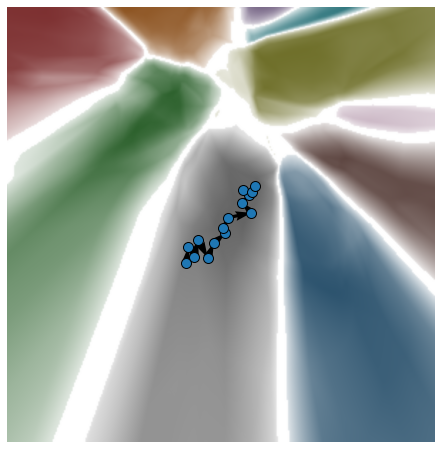

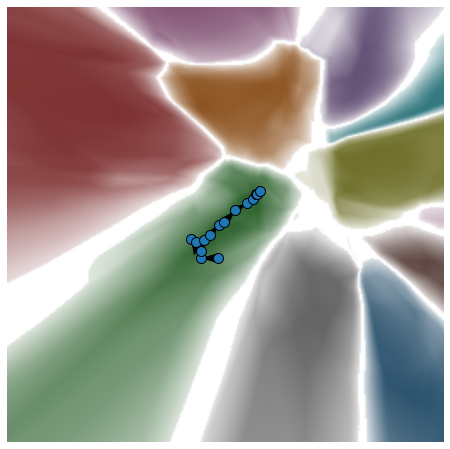

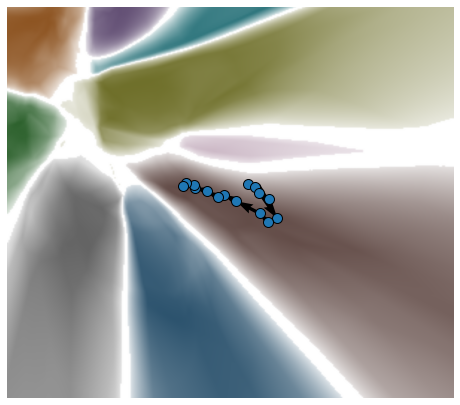

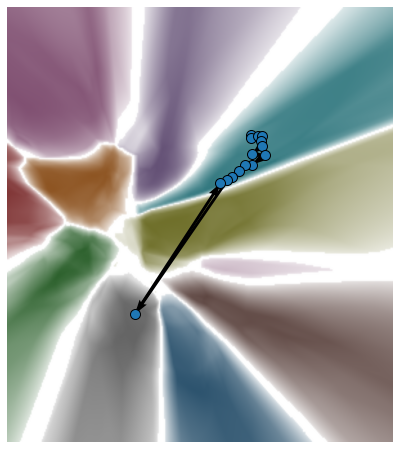

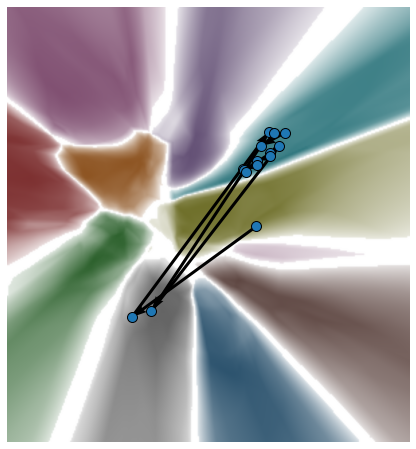

In [12]:
t_s = time.time()
anomaly = 0
# true sample
samples = np.zeros((TOTOAL_EPOCH, 10000, 512))
for i in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
    e = (i-EPOCH_START)//EPOCH_PERIOD
    samples[e] = data_provider.test_representation(i)

embeddings_2d = np.zeros((TOTOAL_EPOCH, 10000, 2))
for e in range(1, TOTOAL_EPOCH+1, 1):
    embeddings_2d[e-1] = projector.batch_project(e, samples[e-1])
embeddings_2d = np.transpose(embeddings_2d, [1,0,2])

tmp = 0
for i in range(10000):
    scores = tm.score_new_sample(embeddings_2d[i][-tm.period:])
    anomaly = anomaly+ detect_anomaly(scores)
    print(scores, detect_anomaly(scores))
    if tmp<anomaly_score(scores):
        tmp = anomaly_score(scores)
        xy_limit = (embeddings_2d[i][:, 0].min()-5, embeddings_2d[i][:, 1].min()-5, embeddings_2d[i][:, 0].max()+5, embeddings_2d[i][:, 1].max()+5)
        vis.savefig_trajectory(15, embeddings_2d[i][:, 0], embeddings_2d[i][:, 1], xy_limit=xy_limit, path="./vis_{}".format(i))
        print(i)
    if max_anomaly(scores):
        break
    # if min_anomaly(scores):
    #     xy_limit = (embeddings_2d[i][:, 0].min()-5, embeddings_2d[i][:, 1].min()-5, embeddings_2d[i][:, 0].max()+5, embeddings_2d[i][:, 1].max()+5)
    #     vis.savefig_trajectory(15, embeddings_2d[i][:, 0], embeddings_2d[i][:, 1], xy_limit=xy_limit, path="./vis_normal_{}".format(i))
t_e = time.time()
print(anomaly/batch_size, round(t_e-t_s, 2))

In [14]:
# # mixup
# t_s = time.time()
# anomaly = 0

# samples = np.zeros((TOTOAL_EPOCH, LEN, 512))
# for i in range(EPOCH_START, EPOCH_END, EPOCH_PERIOD):
#     e = (i-EPOCH_START)//EPOCH_PERIOD
#     samples[e] = data_provider.train_representation(i)
# labels = data_provider.train_labels(20)

# for i in range(50):
#     while True:
#         idx1, idx2 = np.random.choice(LEN, 2, replace=False)
#         if labels[idx1]!=labels[idx2]:
#             break

#     mixup = 0.5*samples[:,idx1,:]+0.5*samples[:,idx2,:]+0.5
#     embedding_2d = np.zeros((TOTOAL_EPOCH,2))
#     for e in range(1, TOTOAL_EPOCH+1, 1):
#         embedding_2d[e-1] = projector.batch_project(e, mixup[np.newaxis,e-1])[0]
#     scores = tm.score_new_sample(embedding_2d[-tm.period:])
#     anomaly = anomaly+ detect_anomaly(scores)
#     print(scores, detect_anomaly(scores))

# t_e = time.time()
# print(anomaly/50, round(t_e-t_s, 2))

(0.9959666666666667, 0.92625, 0.9968) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6605.39it/s]


(0.9999833333333333, 0.9999833333333333, 0.9999833333333333) True
(0.9656333333333333, 0.9970333333333333, 0.9972333333333333) False
(0.9999833333333333, 0.9676166666666667, 0.9719666666666666) False
(0.9959666666666667, 0.9999833333333333, 0.9912166666666666) True
(0.9999833333333333, 0.9999833333333333, 0.9999833333333333) True
(0.9999833333333333, 0.92625, 0.9999833333333333) False
(0.9999833333333333, 0.9999833333333333, 0.9999833333333333) True
(0.9045333333333333, 0.9999833333333333, 0.9999833333333333) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6643.82it/s]


(0.9999833333333333, 0.9556333333333333, 0.9972333333333333) False
(0.9959666666666667, 0.9947333333333334, 0.9968) True
(0.9999833333333333, 0.9999833333333333, 0.9043833333333333) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6452.31it/s]


(0.9045333333333333, 0.92625, 0.8713) False
Computing decision regions ...


100%|██████████| 450/450 [00:00<00:00, 6339.81it/s]


(0.9959666666666667, 0.9999833333333333, 0.9999833333333333) True
(0.9146166666666666, 0.9999833333333333, 0.9912166666666666) False
(0.9999833333333333, 0.9676166666666667, 0.9964333333333333) False
(0.9045333333333333, 0.93225, 0.8713) False
(0.9959666666666667, 0.9970333333333333, 0.9972333333333333) True
(0.9959666666666667, 0.9999833333333333, 0.9972333333333333) True
(0.9959666666666667, 0.9999833333333333, 0.9999833333333333) True
(0.9656333333333333, 0.9970333333333333, 0.9972333333333333) False
(0.9999833333333333, 0.92625, 0.9999833333333333) False
(0.9999833333333333, 0.9999833333333333, 0.9468833333333333) False
(0.9999833333333333, 0.9970333333333333, 0.9999833333333333) True
(0.9999833333333333, 0.92625, 0.9043833333333333) False
(0.9999833333333333, 0.9970333333333333, 0.8713) False
(0.9959666666666667, 0.9999833333333333, 0.9999833333333333) True
(0.9999833333333333, 0.9999833333333333, 0.8713) False
(0.9146166666666666, 0.9676166666666667, 0.9972333333333333) False
(0.

100%|██████████| 450/450 [00:00<00:00, 6128.88it/s]


(0.9999833333333333, 0.9999833333333333, 0.9999833333333333) True
(0.9045333333333333, 0.9947333333333334, 0.9968) False
(0.9999833333333333, 0.9676166666666667, 0.9999833333333333) False
(0.9045333333333333, 0.9999833333333333, 0.9043833333333333) False
(0.9999833333333333, 0.95035, 0.9972333333333333) False
(0.9959666666666667, 0.9999833333333333, 0.9999833333333333) True
(0.9999833333333333, 0.92625, 0.8713) False
(0.9959666666666667, 0.9970333333333333, 0.9968) True
(0.9959666666666667, 0.9676166666666667, 0.9970333333333333) False
(0.9959666666666667, 0.9999833333333333, 0.9999833333333333) True
(0.9656333333333333, 0.9676166666666667, 0.9450666666666667) False
(0.9999833333333333, 0.9999833333333333, 0.9999833333333333) True
(0.9959666666666667, 0.9999833333333333, 0.9999833333333333) True
(0.9999833333333333, 0.95525, 0.9649666666666666) False
(0.9999833333333333, 0.9985333333333334, 0.9912166666666666) True
(0.9045333333333333, 0.9676166666666667, 0.9301) False
(0.9999833333333

KeyboardInterrupt: 

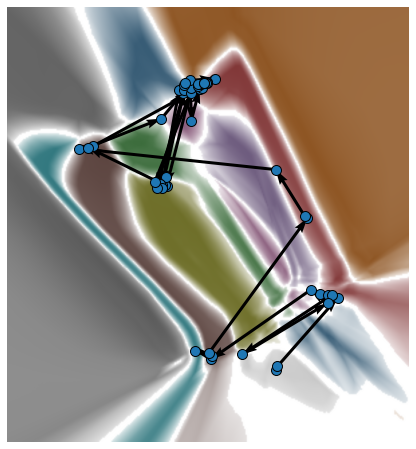

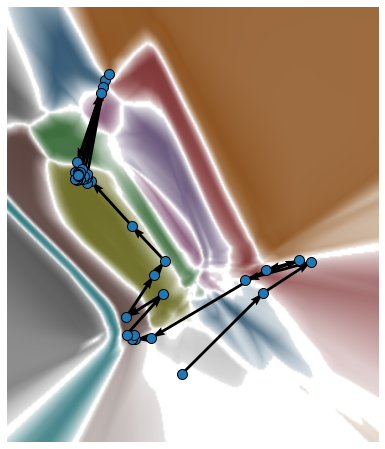

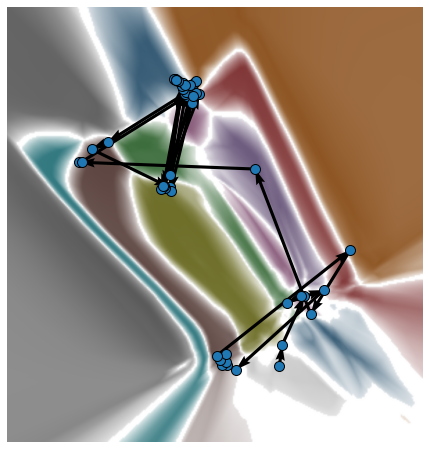

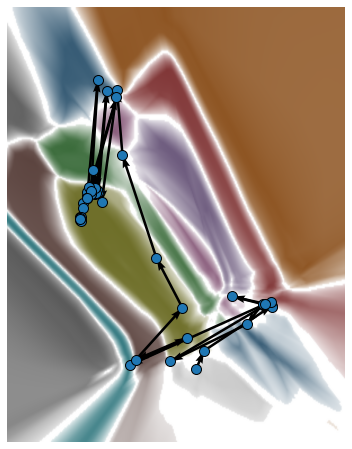

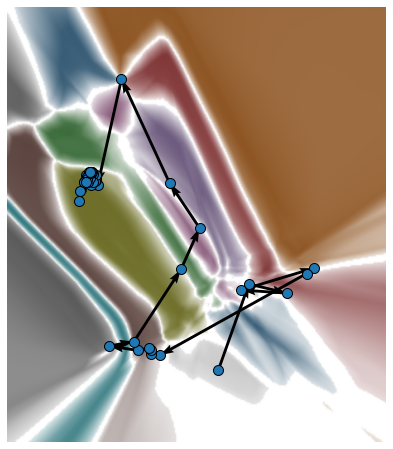

In [11]:
# OOD
anomaly = 0
tmp = 10
t_s = time.time()
for batch, (img, target) in enumerate(train_loader):
    image = img.detach().cpu().numpy()
    if dataset == "mnist":
        image = image[:, :1, :28,:28]
    if dataset == "cifar10":
        image = np.pad(image, ((0,0),(1,1), (2, 2), (2, 2)), 'edge')
        # pass
    embedding_2d = np.zeros((TOTOAL_EPOCH, batch_size, 2))
    for i in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
        e = int((i-EPOCH_START)/EPOCH_PERIOD)
        repr = data_provider.feature_function(i)(torch.from_numpy(image).to(DEVICE))
        embedding_2d[e] = projector.batch_project(i, repr.detach().cpu().numpy())
    embedding_2d = np.transpose(embedding_2d, [1,0,2])
    for i in range(batch_size):
        scores, idxs = tm.score_new_sample(embedding_2d[i][-tm.period:], True)
        anomaly = anomaly+ detect_anomaly(scores)
        print(scores, max_anomaly(scores))
        # if max_anomaly(scores):
        #     xy_limit = (embedding_2d[i][:, 0].min()-5, embedding_2d[i][:, 1].min()-5, embedding_2d[i][:, 0].max()+5, embedding_2d[i][:, 1].max()+5)
        #     vis.savefig_trajectory(15, embedding_2d[i][:, 0], embedding_2d[i][:, 1], xy_limit=xy_limit, path="./vis")
        if tmp>anomaly_score(scores):
            tmp = anomaly_score(scores)
            xy_limit = (embedding_2d[i][:, 0].min()-5, embedding_2d[i][:, 1].min()-5, embedding_2d[i][:, 0].max()+5, embedding_2d[i][:, 1].max()+5)
            vis.savefig_trajectory(50, embedding_2d[i][:, 0], embedding_2d[i][:, 1], xy_limit=xy_limit, path="./ood_{}_{}_{}".format(batch, i, idxs))
t_e = time.time()
print(anomaly/batch_size, round(t_e-t_s, 2))
    